# Dechirp 기반 LoRa 심볼 SOM 분석

Raw IQ 대신 **Dechirp 후 FFT 결과**를 사용하여 SOM 학습

**핵심 아이디어:**
- Dechirp = Symbol × Downchirp (conjugate)
- Dechirp 후 FFT하면 각 심볼이 **고유한 frequency bin에 피크**를 가짐
- Symbol k → FFT bin k에 피크

## 1. 라이브러리 임포트

In [22]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')

def _add_project_root_to_syspath() -> Path | None:
    here = Path.cwd().resolve()
    for p in (here, *here.parents):
        if (p / "utils" / "LoRa.py").exists():
            sys.path.insert(0, str(p))
            return p
    return None

PROJECT_ROOT = _add_project_root_to_syspath()
if PROJECT_ROOT is None:
    raise RuntimeError("Could not locate project root containing utils/LoRa.py")

from som import SelfOrganizingMap
from utils.LoRa import LoRa

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

print("모듈 임포트 완료!", "PROJECT_ROOT=", PROJECT_ROOT)

모듈 임포트 완료! PROJECT_ROOT= /home/gwon9906/self-organizing-map


## 2. LoRa 심볼 생성 및 Dechirp

In [23]:
# LoRa 파라미터
SF = 9
BW = 125e3
OSF = 1

lora = LoRa(sf=SF, bw=BW, OSF=OSF)
num_symbols = 2 ** SF

print(f"SF = {SF}")
print(f"심볼 개수 = {num_symbols}")

SF = 9
심볼 개수 = 512


In [24]:
# 모든 심볼 생성 및 Dechirp + FFT
symbols_raw = []
symbols_dechirped = []
symbols_dechirp_fft = []
labels = []

for code_word in range(num_symbols):
    # Raw 심볼
    symbol = lora.gen_symbol(code_word, down=False)
    symbols_raw.append(symbol)
    
    # Dechirp
    dechirped = lora.dechirp(symbol)
    symbols_dechirped.append(dechirped)
    
    # Dechirp + FFT
    dechirp_fft = lora.dechirp_and_fft(symbol)
    symbols_dechirp_fft.append(dechirp_fft)
    
    labels.append(code_word)

symbols_raw = np.array(symbols_raw)
symbols_dechirped = np.array(symbols_dechirped)
symbols_dechirp_fft = np.array(symbols_dechirp_fft)
labels = np.array(labels)

print(f"Raw 심볼 shape: {symbols_raw.shape}")
print(f"Dechirped 심볼 shape: {symbols_dechirped.shape}")
print(f"Dechirp FFT shape: {symbols_dechirp_fft.shape}")

Raw 심볼 shape: (512, 512)
Dechirped 심볼 shape: (512, 512)
Dechirp FFT shape: (512, 512)


## 3. Dechirp 결과 시각화

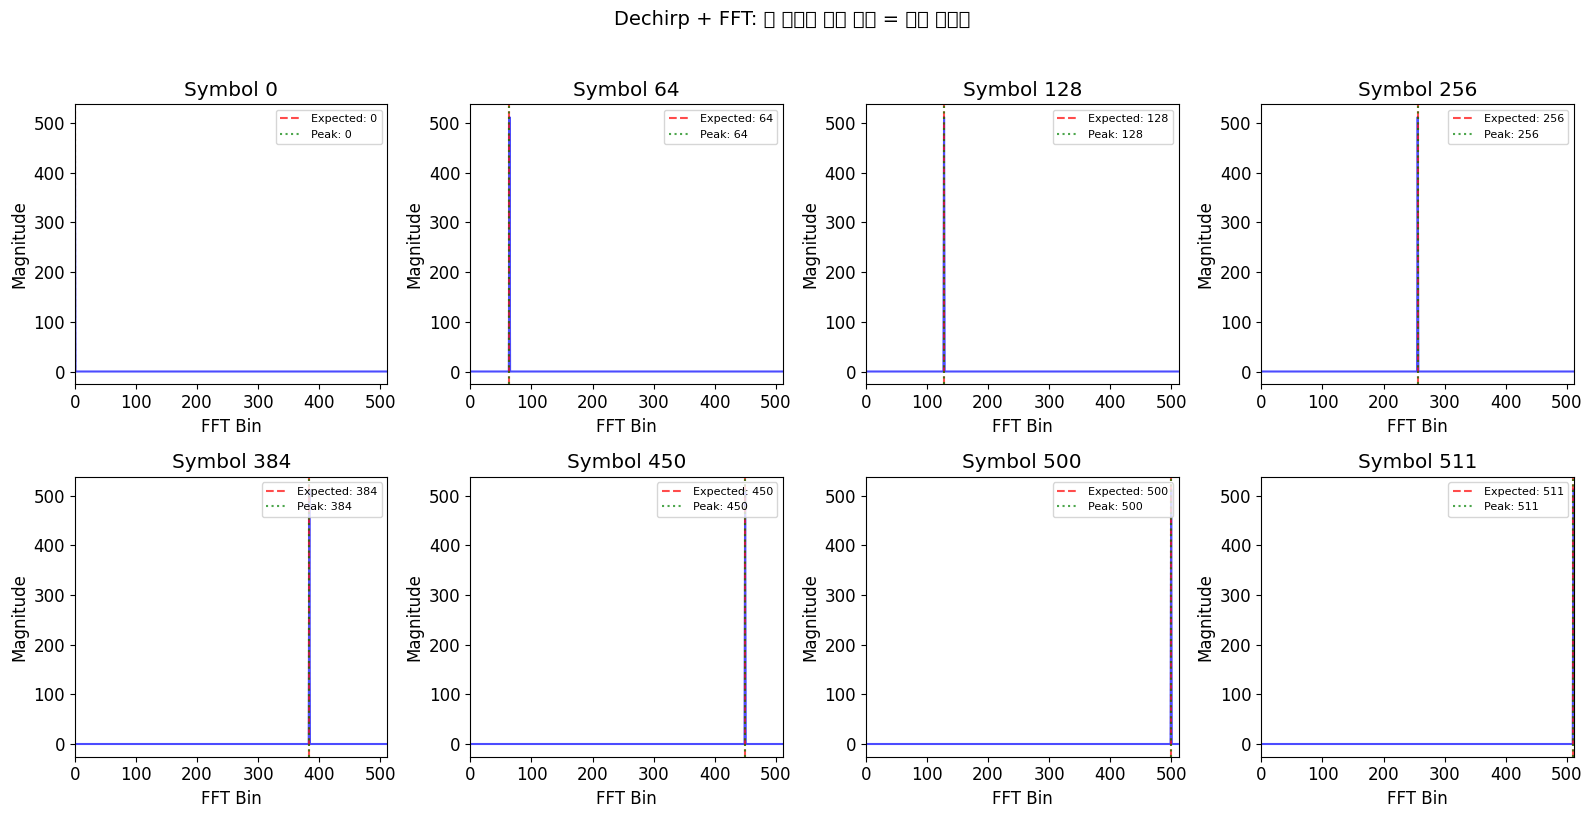

In [25]:
# Dechirp + FFT 결과 확인 (몇 개 심볼)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

sample_symbols = [0, 64, 128, 256, 384, 450, 500, 511]

for idx, (ax, sym_idx) in enumerate(zip(axes.flat, sample_symbols)):
    fft_mag = np.abs(symbols_dechirp_fft[sym_idx])
    
    ax.plot(fft_mag, 'b-', alpha=0.7)
    ax.axvline(x=sym_idx, color='r', linestyle='--', alpha=0.7, label=f'Expected: {sym_idx}')
    
    # 실제 피크 위치
    peak_idx = np.argmax(fft_mag)
    ax.axvline(x=peak_idx, color='g', linestyle=':', alpha=0.7, label=f'Peak: {peak_idx}')
    
    ax.set_title(f'Symbol {sym_idx}')
    ax.set_xlabel('FFT Bin')
    ax.set_ylabel('Magnitude')
    ax.legend(loc='upper right', fontsize=8)
    ax.set_xlim([0, num_symbols])

plt.suptitle('Dechirp + FFT: 각 심볼의 피크 위치 = 심볼 인덱스', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [26]:
# 복조 정확도 확인
correct = 0
for i, symbol in enumerate(symbols_raw):
    estimated = lora.demodulate(symbol)
    if estimated == i:
        correct += 1

print(f"복조 정확도: {correct}/{num_symbols} = {100*correct/num_symbols:.1f}%")

복조 정확도: 512/512 = 100.0%


## 4. SOM을 위한 데이터 준비

Dechirp FFT 결과를 다양한 방식으로 표현:
1. **FFT Magnitude** - 피크 위치 정보
2. **FFT Real + Imag** - 위상 정보 포함
3. **Normalized FFT Magnitude** - 정규화된 스펙트럼

In [27]:
# 방법 1: FFT Magnitude만 사용
data_fft_mag = np.abs(symbols_dechirp_fft)

# 방법 2: FFT Real + Imag
data_fft_ri = np.hstack([symbols_dechirp_fft.real, symbols_dechirp_fft.imag])

# 방법 3: Normalized Magnitude (각 심볼별 최대값으로 정규화)
data_fft_mag_norm = data_fft_mag / (data_fft_mag.max(axis=1, keepdims=True) + 1e-10)

print(f"FFT Magnitude shape: {data_fft_mag.shape}")
print(f"FFT Real+Imag shape: {data_fft_ri.shape}")
print(f"Normalized Magnitude shape: {data_fft_mag_norm.shape}")

FFT Magnitude shape: (512, 512)
FFT Real+Imag shape: (512, 1024)
Normalized Magnitude shape: (512, 512)


In [28]:
# 데이터 정규화 (Z-score)
def normalize_zscore(data):
    return (data - data.mean(axis=0)) / (data.std(axis=0) + 1e-8)

data_mag_normalized = normalize_zscore(data_fft_mag)
data_ri_normalized = normalize_zscore(data_fft_ri)
data_mag_norm_normalized = normalize_zscore(data_fft_mag_norm)

print("정규화 완료!")

정규화 완료!


## 5. SOM 학습 (Dechirp FFT Magnitude)

In [29]:
# SOM 파라미터
MAP_SIZE = (24, 24)
SIGMA = max(MAP_SIZE) / 2
LEARNING_RATE = 0.5
NUM_ITERATIONS = 50000

print(f"SOM 설정:")
print(f"  - Map Size: {MAP_SIZE}")
print(f"  - Sigma: {SIGMA}")
print(f"  - Learning Rate: {LEARNING_RATE}")
print(f"  - Iterations: {NUM_ITERATIONS}")

SOM 설정:
  - Map Size: (24, 24)
  - Sigma: 12.0
  - Learning Rate: 0.5
  - Iterations: 50000


In [30]:
# FFT Magnitude 기반 SOM
som_mag = SelfOrganizingMap(
    map_size=MAP_SIZE,
    input_dim=data_mag_normalized.shape[1],
    sigma=SIGMA,
    learning_rate=LEARNING_RATE,
    decay_function='exponential',
    random_seed=42
)

print("Dechirp FFT Magnitude SOM 학습 시작...\n")
som_mag.train(data_mag_normalized, num_iterations=NUM_ITERATIONS, verbose=True)
print("\n학습 완료!")

Dechirp FFT Magnitude SOM 학습 시작...



KeyboardInterrupt: 

## 6. 학습 결과 시각화

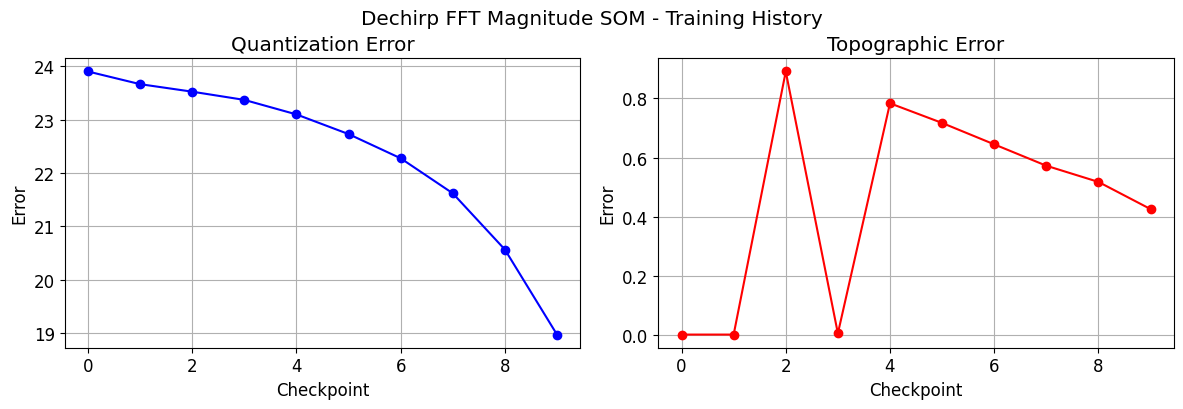

In [ ]:
# Training History
som_mag.plot_training_history()
plt.suptitle('Dechirp FFT Magnitude SOM - Training History', y=1.02)
plt.show()

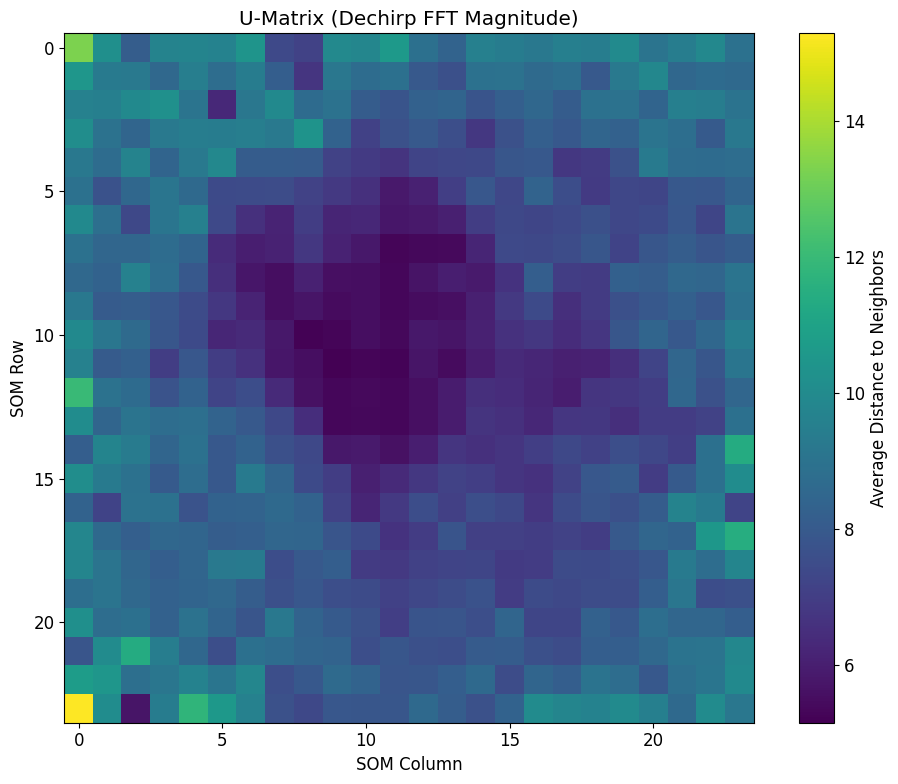

In [ ]:
# U-Matrix
fig, ax = som_mag.plot_u_matrix(figsize=(10, 8), cmap='viridis')
plt.title('U-Matrix (Dechirp FFT Magnitude)')
plt.show()

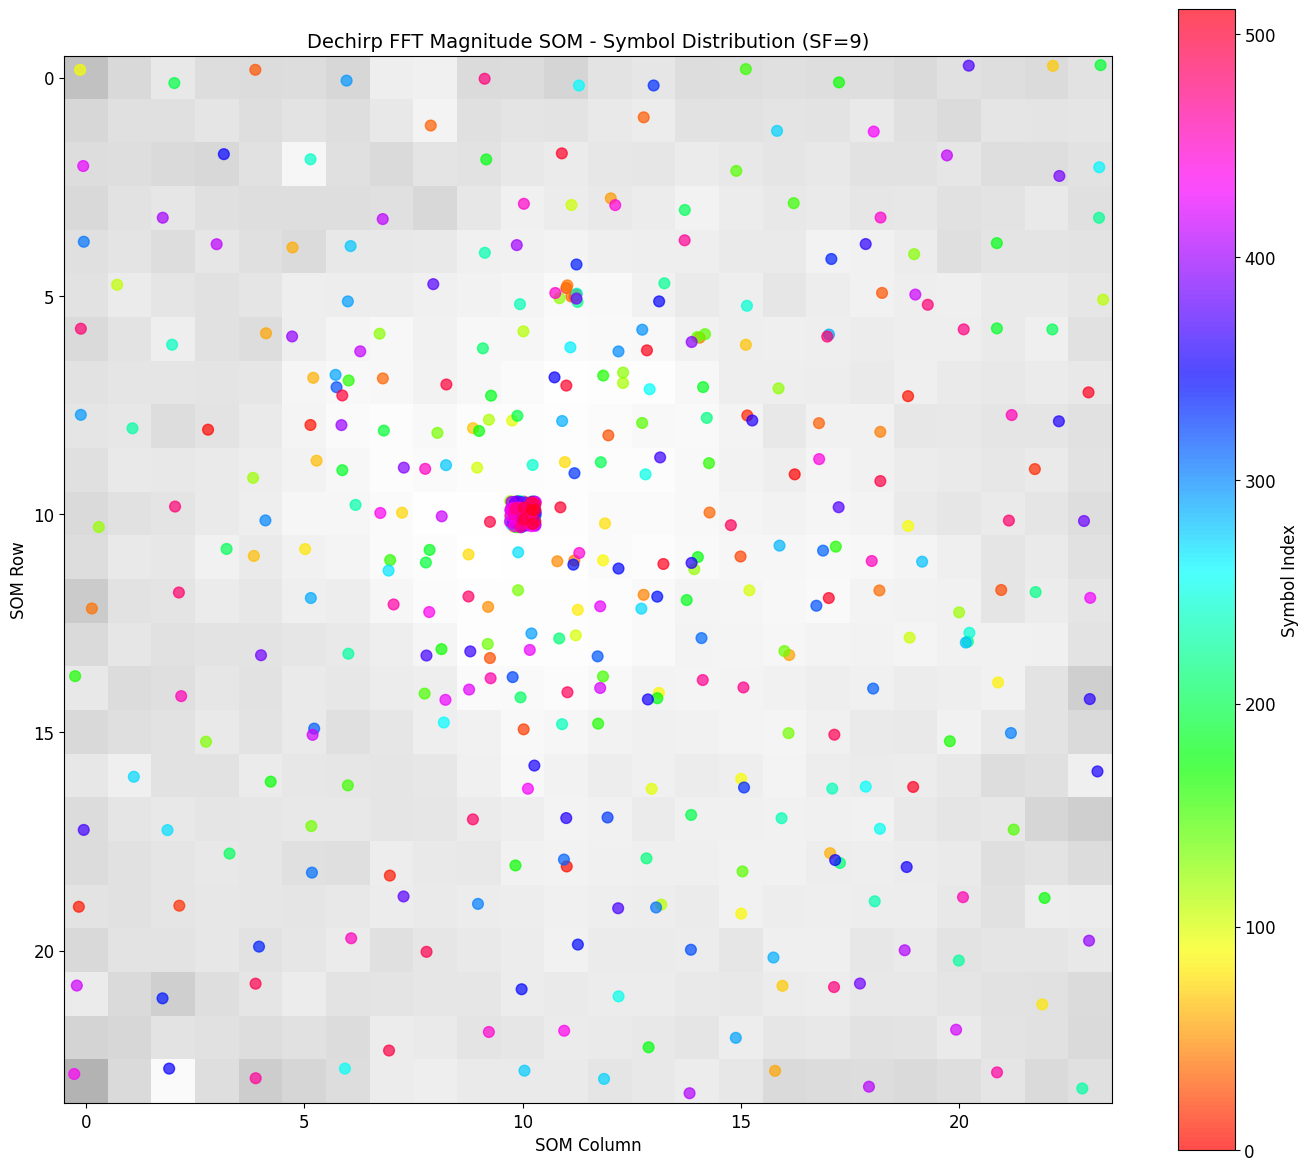

In [ ]:
# BMU 위치 계산
bmu_positions_mag = np.array([som_mag.predict(x) for x in data_mag_normalized])

# 심볼 분포 시각화
fig, ax = plt.subplots(figsize=(14, 12))

u_matrix = som_mag.get_u_matrix()
ax.imshow(u_matrix, cmap='gray_r', alpha=0.3, interpolation='nearest')

scatter = ax.scatter(
    bmu_positions_mag[:, 1] + np.random.uniform(-0.3, 0.3, len(bmu_positions_mag)),
    bmu_positions_mag[:, 0] + np.random.uniform(-0.3, 0.3, len(bmu_positions_mag)),
    c=labels,
    cmap='hsv',
    alpha=0.7,
    s=60
)

plt.colorbar(scatter, ax=ax, label='Symbol Index')
ax.set_xlim(-0.5, MAP_SIZE[1] - 0.5)
ax.set_ylim(MAP_SIZE[0] - 0.5, -0.5)
ax.set_title('Dechirp FFT Magnitude SOM - Symbol Distribution (SF=9)', fontsize=14)
ax.set_xlabel('SOM Column')
ax.set_ylabel('SOM Row')
plt.tight_layout()
plt.show()

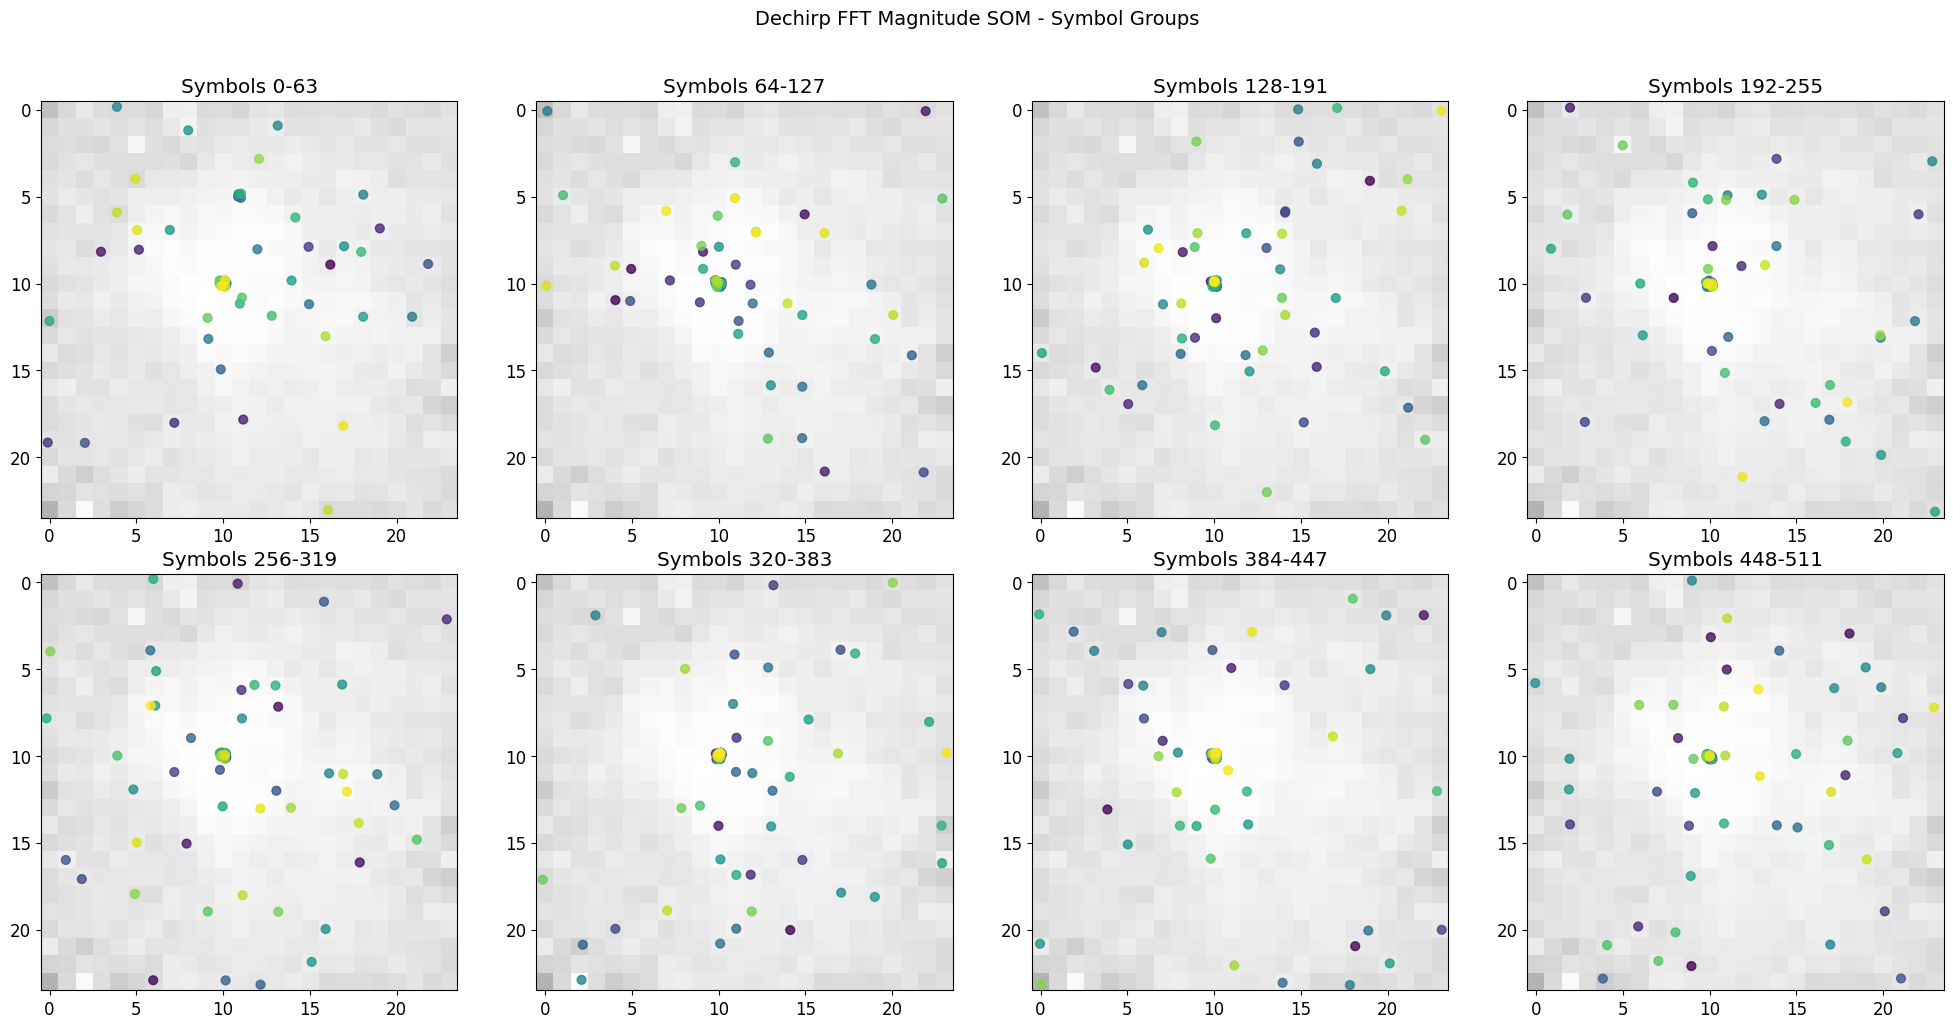

In [ ]:
# 그룹별 시각화
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

group_size = num_symbols // 8

for i, ax in enumerate(axes.flat):
    start_idx = i * group_size
    end_idx = (i + 1) * group_size
    
    ax.imshow(u_matrix, cmap='gray_r', alpha=0.3, interpolation='nearest')
    
    mask = (labels >= start_idx) & (labels < end_idx)
    group_positions = bmu_positions_mag[mask]
    group_labels = labels[mask]
    
    scatter = ax.scatter(
        group_positions[:, 1] + np.random.uniform(-0.2, 0.2, len(group_positions)),
        group_positions[:, 0] + np.random.uniform(-0.2, 0.2, len(group_positions)),
        c=group_labels,
        cmap='viridis',
        alpha=0.8,
        s=40
    )
    
    ax.set_xlim(-0.5, MAP_SIZE[1] - 0.5)
    ax.set_ylim(MAP_SIZE[0] - 0.5, -0.5)
    ax.set_title(f'Symbols {start_idx}-{end_idx-1}')

plt.suptitle('Dechirp FFT Magnitude SOM - Symbol Groups', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 7. Raw IQ vs Dechirp 비교

In [ ]:
# Raw IQ SOM (비교용)
data_raw = np.hstack([symbols_raw.real, symbols_raw.imag])
data_raw_normalized = normalize_zscore(data_raw)

som_raw = SelfOrganizingMap(
    map_size=MAP_SIZE,
    input_dim=data_raw_normalized.shape[1],
    sigma=SIGMA,
    learning_rate=LEARNING_RATE,
    decay_function='exponential',
    random_seed=42
)

print("Raw IQ SOM 학습 시작...\n")
som_raw.train(data_raw_normalized, num_iterations=NUM_ITERATIONS, verbose=True)
print("\n학습 완료!")

Raw IQ SOM 학습 시작...

Iteration 5000/50000 - QE: 33.6789, TE: 0.0000, LR: 0.4801, σ: 9.2856
Iteration 10000/50000 - QE: 33.3904, TE: 0.0020, LR: 0.4611, σ: 7.1848
Iteration 15000/50000 - QE: 33.1138, TE: 0.0059, LR: 0.4427, σ: 5.5593
Iteration 20000/50000 - QE: 32.9579, TE: 0.0156, LR: 0.4251, σ: 4.3016
Iteration 25000/50000 - QE: 32.6691, TE: 0.3887, LR: 0.4083, σ: 3.3284
Iteration 30000/50000 - QE: 32.0876, TE: 0.0449, LR: 0.3920, σ: 2.5754
Iteration 35000/50000 - QE: 31.5443, TE: 0.0938, LR: 0.3765, σ: 1.9927
Iteration 40000/50000 - QE: 30.4500, TE: 0.5508, LR: 0.3615, σ: 1.5419
Iteration 45000/50000 - QE: 29.0219, TE: 0.5156, LR: 0.3471, σ: 1.1930
Iteration 50000/50000 - QE: 26.9579, TE: 0.4609, LR: 0.3333, σ: 0.9231

학습 완료!


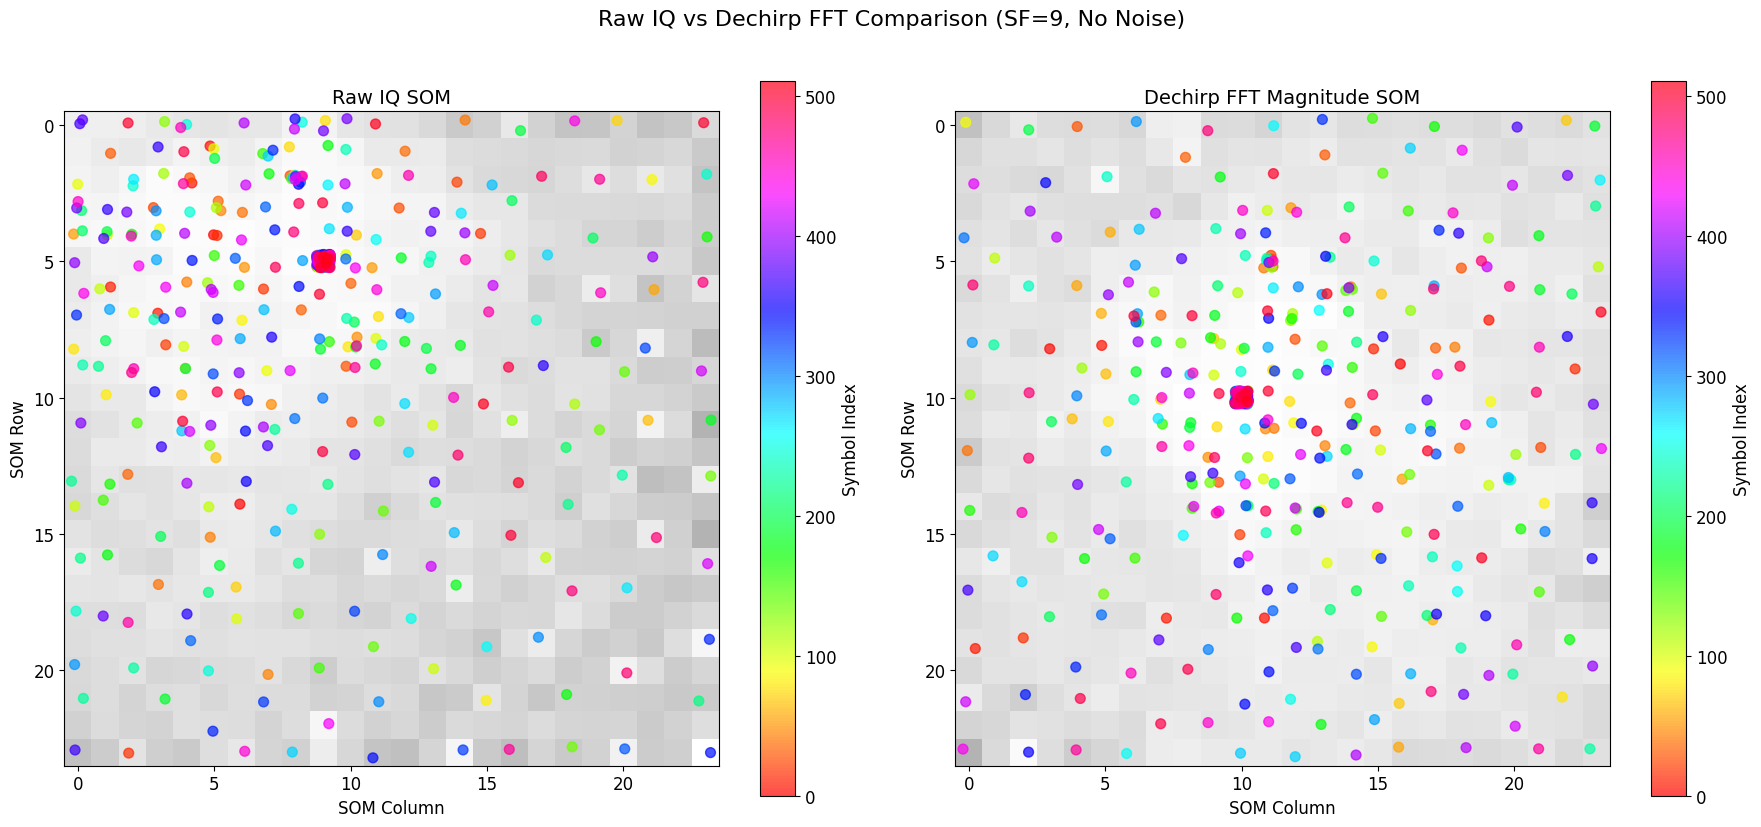

In [ ]:
# Raw vs Dechirp 비교
bmu_positions_raw = np.array([som_raw.predict(x) for x in data_raw_normalized])

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Raw IQ
u_matrix_raw = som_raw.get_u_matrix()
axes[0].imshow(u_matrix_raw, cmap='gray_r', alpha=0.3, interpolation='nearest')
scatter1 = axes[0].scatter(
    bmu_positions_raw[:, 1] + np.random.uniform(-0.25, 0.25, len(bmu_positions_raw)),
    bmu_positions_raw[:, 0] + np.random.uniform(-0.25, 0.25, len(bmu_positions_raw)),
    c=labels, cmap='hsv', alpha=0.7, s=50
)
axes[0].set_xlim(-0.5, MAP_SIZE[1] - 0.5)
axes[0].set_ylim(MAP_SIZE[0] - 0.5, -0.5)
axes[0].set_title('Raw IQ SOM', fontsize=14)
axes[0].set_xlabel('SOM Column')
axes[0].set_ylabel('SOM Row')
plt.colorbar(scatter1, ax=axes[0], label='Symbol Index')

# Dechirp FFT
axes[1].imshow(u_matrix, cmap='gray_r', alpha=0.3, interpolation='nearest')
scatter2 = axes[1].scatter(
    bmu_positions_mag[:, 1] + np.random.uniform(-0.25, 0.25, len(bmu_positions_mag)),
    bmu_positions_mag[:, 0] + np.random.uniform(-0.25, 0.25, len(bmu_positions_mag)),
    c=labels, cmap='hsv', alpha=0.7, s=50
)
axes[1].set_xlim(-0.5, MAP_SIZE[1] - 0.5)
axes[1].set_ylim(MAP_SIZE[0] - 0.5, -0.5)
axes[1].set_title('Dechirp FFT Magnitude SOM', fontsize=14)
axes[1].set_xlabel('SOM Column')
axes[1].set_ylabel('SOM Row')
plt.colorbar(scatter2, ax=axes[1], label='Symbol Index')

plt.suptitle('Raw IQ vs Dechirp FFT Comparison (SF=9, No Noise)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## 8. 토폴로지 보존 분석

In [ ]:
# 연속 심볼 간 BMU 거리
def calc_consecutive_distances(bmu_positions):
    distances = []
    for i in range(len(bmu_positions) - 1):
        dist = np.sqrt((bmu_positions[i, 0] - bmu_positions[i+1, 0])**2 + 
                       (bmu_positions[i, 1] - bmu_positions[i+1, 1])**2)
        distances.append(dist)
    # Circular (511 -> 0)
    dist = np.sqrt((bmu_positions[-1, 0] - bmu_positions[0, 0])**2 + 
                   (bmu_positions[-1, 1] - bmu_positions[0, 1])**2)
    distances.append(dist)
    return np.array(distances)

dist_raw = calc_consecutive_distances(bmu_positions_raw)
dist_dechirp = calc_consecutive_distances(bmu_positions_mag)

print("연속 심볼 간 BMU 거리 통계:")
print(f"\n[Raw IQ]")
print(f"  평균: {dist_raw.mean():.3f}, 표준편차: {dist_raw.std():.3f}")
print(f"  최소: {dist_raw.min():.3f}, 최대: {dist_raw.max():.3f}")

print(f"\n[Dechirp FFT]")
print(f"  평균: {dist_dechirp.mean():.3f}, 표준편차: {dist_dechirp.std():.3f}")
print(f"  최소: {dist_dechirp.min():.3f}, 최대: {dist_dechirp.max():.3f}")

연속 심볼 간 BMU 거리 통계:

[Raw IQ]
  평균: 8.079, 표준편차: 5.776
  최소: 0.000, 최대: 28.018

[Dechirp FFT]
  평균: 8.142, 표준편차: 5.722
  최소: 0.000, 최대: 26.627


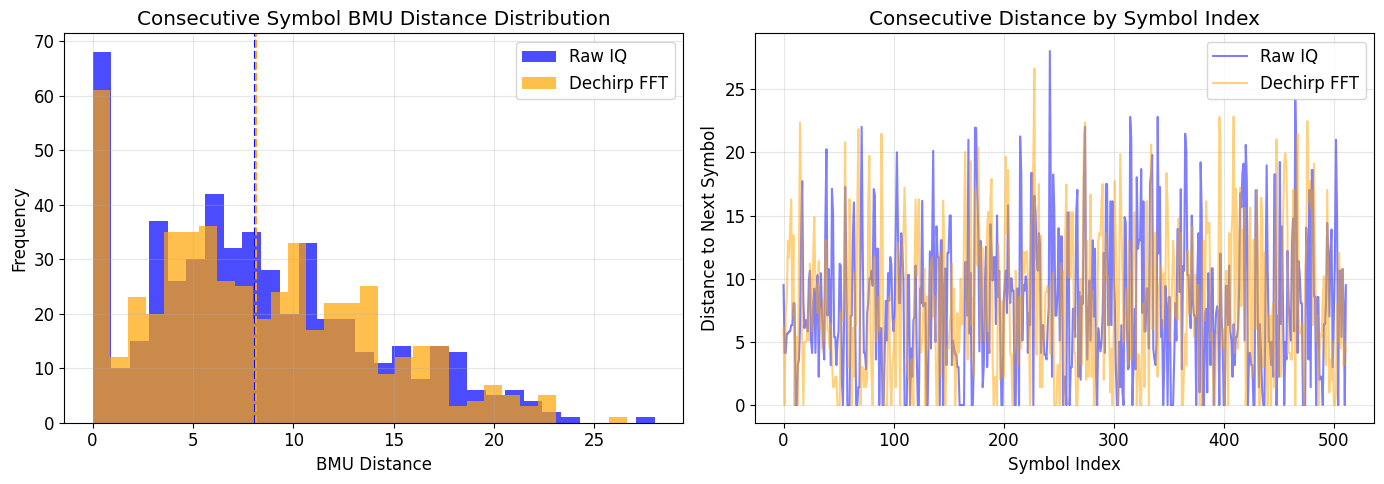

In [ ]:
# 거리 분포 비교
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(dist_raw, bins=30, alpha=0.7, label='Raw IQ', color='blue')
axes[0].hist(dist_dechirp, bins=30, alpha=0.7, label='Dechirp FFT', color='orange')
axes[0].axvline(dist_raw.mean(), color='blue', linestyle='--')
axes[0].axvline(dist_dechirp.mean(), color='orange', linestyle='--')
axes[0].set_xlabel('BMU Distance')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Consecutive Symbol BMU Distance Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 심볼 인덱스별 거리
axes[1].plot(dist_raw, 'b-', alpha=0.5, label='Raw IQ')
axes[1].plot(dist_dechirp, 'orange', alpha=0.5, label='Dechirp FFT')
axes[1].set_xlabel('Symbol Index')
axes[1].set_ylabel('Distance to Next Symbol')
axes[1].set_title('Consecutive Distance by Symbol Index')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. 최종 비교 및 결론

In [ ]:
print("=" * 60)
print("최종 결과 비교")
print("=" * 60)

print(f"\n[Raw IQ SOM]")
print(f"  Quantization Error: {som_raw.quantization_error(data_raw_normalized):.4f}")
print(f"  Topographic Error: {som_raw.topographic_error(data_raw_normalized):.4f}")
print(f"  연속 심볼 평균 거리: {dist_raw.mean():.3f}")

print(f"\n[Dechirp FFT Magnitude SOM]")
print(f"  Quantization Error: {som_mag.quantization_error(data_mag_normalized):.4f}")
print(f"  Topographic Error: {som_mag.topographic_error(data_mag_normalized):.4f}")
print(f"  연속 심볼 평균 거리: {dist_dechirp.mean():.3f}")

print("\n" + "=" * 60)
print("결론:")
print("- Dechirp 후 FFT는 각 심볼의 고유한 특징을 추출")
print("- 심볼 인덱스에 따른 연속적 토폴로지 형성 여부 확인")
print("- Topographic Error 감소 = 더 좋은 토폴로지 보존")
print("=" * 60)

최종 결과 비교

[Raw IQ SOM]
  Quantization Error: 26.9579
  Topographic Error: 0.4609
  연속 심볼 평균 거리: 8.079

[Dechirp FFT Magnitude SOM]
  Quantization Error: 18.9727
  Topographic Error: 0.4258
  연속 심볼 평균 거리: 8.142

결론:
- Dechirp 후 FFT는 각 심볼의 고유한 특징을 추출
- 심볼 인덱스에 따른 연속적 토폴로지 형성 여부 확인
- Topographic Error 감소 = 더 좋은 토폴로지 보존


## 10. BMU 경로 시각화 (토폴로지 확인)

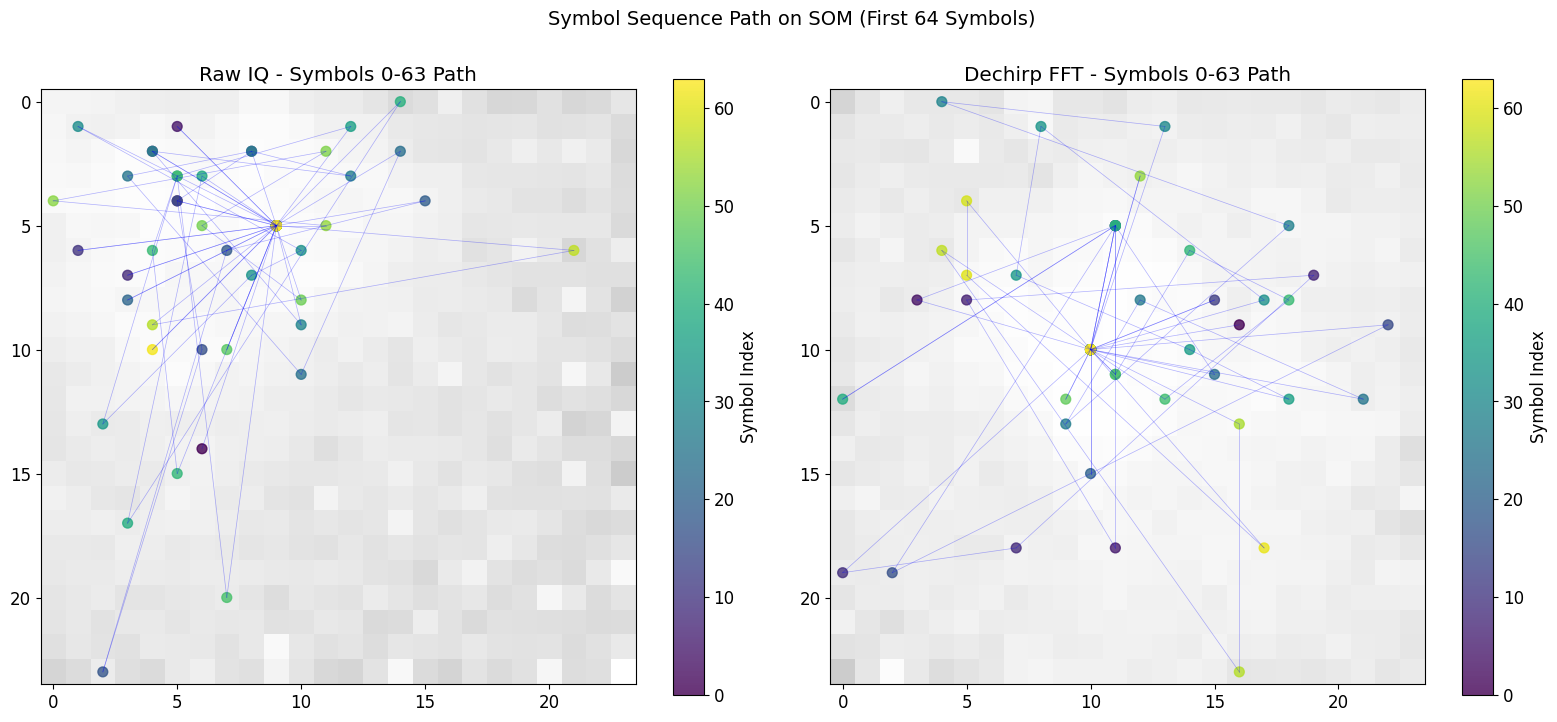

In [ ]:
# 심볼 순서대로 BMU 연결 (처음 64개만)
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

n_show = 64  # 처음 64개 심볼만

for ax, bmu_pos, title in [(axes[0], bmu_positions_raw, 'Raw IQ'),
                           (axes[1], bmu_positions_mag, 'Dechirp FFT')]:
    # U-Matrix 배경
    if 'Raw' in title:
        ax.imshow(u_matrix_raw, cmap='gray_r', alpha=0.2, interpolation='nearest')
    else:
        ax.imshow(u_matrix, cmap='gray_r', alpha=0.2, interpolation='nearest')
    
    # 연결선
    for i in range(n_show - 1):
        ax.plot([bmu_pos[i, 1], bmu_pos[i+1, 1]], 
                [bmu_pos[i, 0], bmu_pos[i+1, 0]], 
                'b-', alpha=0.3, linewidth=0.5)
    
    # 점
    scatter = ax.scatter(
        bmu_pos[:n_show, 1],
        bmu_pos[:n_show, 0],
        c=np.arange(n_show),
        cmap='viridis',
        s=50,
        alpha=0.8
    )
    
    ax.set_xlim(-0.5, MAP_SIZE[1] - 0.5)
    ax.set_ylim(MAP_SIZE[0] - 0.5, -0.5)
    ax.set_title(f'{title} - Symbols 0-{n_show-1} Path')
    plt.colorbar(scatter, ax=ax, label='Symbol Index')

plt.suptitle('Symbol Sequence Path on SOM (First 64 Symbols)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()